<a href="https://colab.research.google.com/github/TALeonard/19ma573thomasleonard/blob/master/src/hw4_bsm_geometric_asian_option_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this, I will use the specific versions of the files the assignment requests; i.e. using the contract_v01 and sde_1d_v01 files. Thus, I have made a fork of the public MA 573 repo, from which I can ! git clone.

In [1]:
#!git clone https://github.com/TALeonard/18ma573pub.git #Only run once!

Cloning into '18ma573pub'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 753 (delta 75), reused 74 (delta 25), pack-reused 605
Receiving objects: 100% (753/753), 2.37 MiB | 24.97 MiB/s, done.
Resolving deltas: 100% (438/438), done.


In [2]:
cd /content/18ma573pub/src/

/content/18ma573pub/src


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from contract_v01 import VanillaOption
from sde_1d_v01 import Sde_1d, Gbm_1d

Now, create the asian option price code.

In [0]:
'''==============
output: BSM geometric asian option price
==============='''

def bsm_geometric_asian_price(self,
                             otype = 1,
                             strike = 110,
                             maturity = 1,
                             num_step = 4 #partition number
                             ):
  s0 = self.init_state
  sigma = self.vol_ratio
  r = self.drift_ratio
  n = num_step
  
  #NOTE: This price assumes a uniform partition time steps, for ease of coding.
  
  #Want to compute r-hat and sigma-hat for the price itself.
  #r-hat = mu-hat + 1/2(sigma-hat^2)
  #Thus for r-hat we need mu-hat, and sigma-hat
  
  #Compute mu-hat
  #mu-hat = mu/2 (we are assuming uniform partition as stated above)
  mu = r - 0.5*(sigma**2)
  mu_hat = (mu/2)
  
  #Compute sigma-hat
  #Sigma-hat^2 = (sigma^2 * (2m + 1))/(6*(m+1)) where m is the number of steps.
  #Recall that the vol_ratio is sigma, not sigma^2. Thus we need both.
  sigma_hat_squared = ((sigma**2)*((2*n) + 1))/(6*(n+1))
  sigma_hat = sigma_hat_squared ** 0.5
  
  #With mu-hat and sigma-hat calculated, we can find r-hat.
  r_hat = mu_hat + (0.5 * sigma_hat_squared)
  
  #Create a separate GBM variable to store the new sigma and r, for the sake of
  #computing the price.
  
  gao_internal_gbm = Gbm_1d(init_state=s0,drift_ratio = r_hat,vol_ratio = sigma_hat)
  
  return np.exp((r_hat - r)*maturity) * gao_internal_gbm.bsm_price(VanillaOption(otype,strike,maturity))

Gbm_1d.bsm_geometric_asian_price = bsm_geometric_asian_price

Now test to make sure the above matches the lecture information.

In [57]:
gbm1 = Gbm_1d(init_state = 100, drift_ratio = 0.0475, vol_ratio = 0.2)
gao1 = gbm1.bsm_geometric_asian_price(
                          otype = 1,
                          strike = 110,
                          maturity = 1,
                          num_step = 4
                          )
print('>>>>>> geometric call option value is ' + str(gao1))

>>>>>> geometric call option value is 1.607164727431734


This matches the output in the Geometric Asian Option notes. Now, attempt calibration using given data.

In [0]:
'''==============
market available data
==============='''
#paras for stock price
spot = 100
rate = 0.05

#paras for geometric asian options
otype = 1
maturity = 2/12
num_steps = 8
strike_list = [97, 99, 101, 103]
market_price_list = [
    3.7925736094875964,
    2.5429985313737244,
    1.6026613800895042,
    0.9366198675047346]

In [0]:
'''==============
calibrated volatility based on vanilla options
==============='''
calibrated_vol = 0.18109375000000028

In [0]:
'''==============
My code below for the calibration
==============='''
#Update GBM variables
gbm1.vol_ratio = calibrated_vol
gbm1.drift_ratio = rate
gbm1.init_state = spot

#Populate list of options based on given strike, maturity, and market price
cal_option_price_list = []
for i in range(len(strike_list)):
  option1 = gbm1.bsm_geometric_asian_price(
    otype = otype,
    strike = strike_list[i],
    maturity = maturity,
    num_step = num_steps
  )
  
  cal_option_price_list.append(option1)

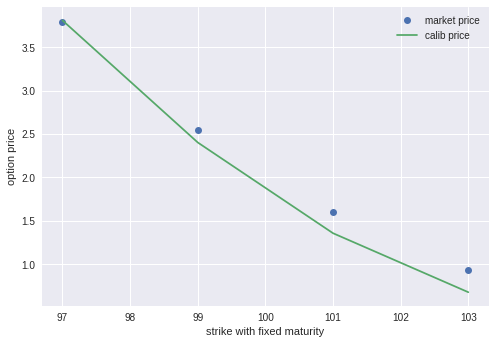

In [61]:
#Now, graph the calibrated and actual prices to see how they compare.

x_co = [strike_list[i] for i in range(len(strike_list))]
y_co = [market_price_list[i] for i in range(len(market_price_list))]
plt.plot(x_co, y_co, 'o', label='market price')

y_co = [cal_option_price_list[i] for i in 
        range(len(cal_option_price_list))]
plt.plot(x_co, y_co, label = 'calib price')

plt.ylabel('option price')
plt.xlabel('strike with fixed maturity')
plt.legend();

Now, compare prices as before to see how well this calibration performed.

In [0]:
#create list of differences between real price and calibrated price.
price_delta = [market_price_list[i] - cal_option_price_list[i] 
              for i in range(len(cal_option_price_list))]

In [0]:
delta_list = [] #empty vector to store the price deltas in, for display purposes.
for i in range(len(strike_list)):
  delta = [strike_list[i], price_delta[i]]
  delta_list.append(delta)

In [66]:
display_table = np.array(delta_list)
print(display_table)

[[ 9.70000000e+01 -1.49979725e-02]
 [ 9.90000000e+01  1.40938504e-01]
 [ 1.01000000e+02  2.45476248e-01]
 [ 1.03000000e+02  2.58702379e-01]]


In all 4 cases, the error of the calibrated price is less than 0.26. Consider relative error for a more accurate view.

In [0]:
relative_delta_price = [price_delta[i]/market_price_list[i]
           for i in range(len(market_price_list))]

In [69]:
relative_delta_list = []
for i in range(len(strike_list)):
  relative_delta = [strike_list[i], relative_delta_price[i]]
  relative_delta_list.append(relative_delta)
  
relative_display_table = np.array(relative_delta_list)
print(relative_display_table)

[[ 9.70000000e+01 -3.95456333e-03]
 [ 9.90000000e+01  5.54221729e-02]
 [ 1.01000000e+02  1.53167881e-01]
 [ 1.03000000e+02  2.76208511e-01]]


In [70]:
print(relative_delta_price)

[-0.003954563333570218, 0.055422172943970206, 0.15316788117124921, 0.2762085107364385]


These predictions are not as accurate as they were during the calibration for the less exotic option. I believe this to be a result of 3 factors:

1. We have fewer values to calibrate with than the example in 4-1. There, I used 8 prices, which meant I had 8 data points to work with.
2. The asian option is not what the volatility was calibrated with, thus it may not be as reliable of a measure for it (as in, we're attempting to extend something outside its original intended scope which can cause approximation issues).
3. The prices of the asian options are, on a whole, very small. Thus, small errors like 0.258 represent a much more significant percentage than they do in 4.1 (where the largest error was actually -0.75, but due to prices this was only a -3.7% error).

Based on this, I am willing to accept my current calibration, though only tentatively.